In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
base = automap_base()

# Use the Base class to reflect the database tables
base.prepare(engine, reflect = True)

/var/folders/xp/092bhmwj1z570jmzpt1j00dr0000gn/T/ipykernel_10514/3587875216.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect = True)


In [6]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
measurement = base.classes.measurement
station = base.classes.station

In [7]:
# Print all of the classes mapped to the Base
print(base.classes.keys())

['station', 'measurement']


In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).first()[0]
recent_date

'2017-08-23'

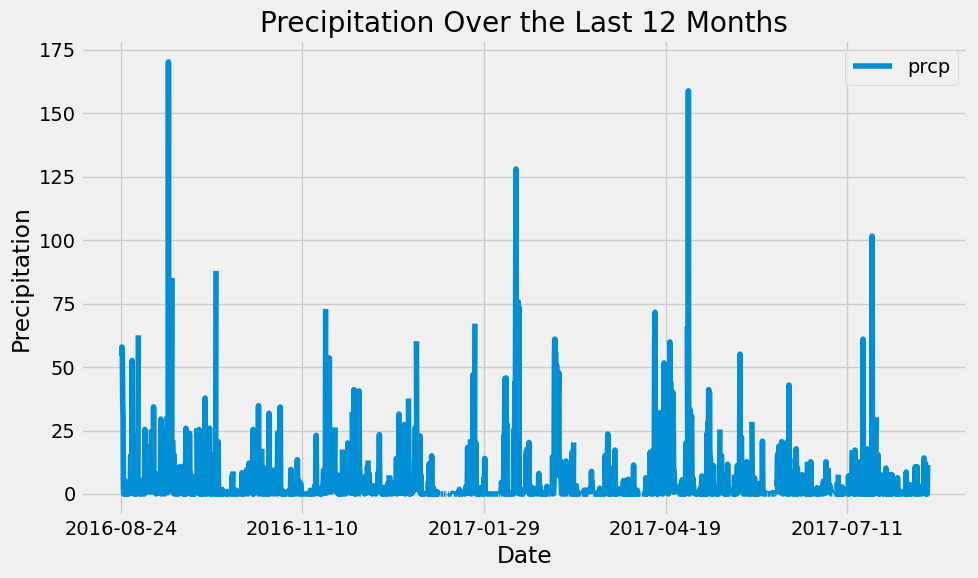

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
#Starting from the most recent data point in the database.
recent_date_dt = dt.datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data, columns = ['date', 'prcp'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x = 'date', y = 'prcp', figsize = (10,6), title = 'Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_statistics = session.query(func.count(station.station)).all()
total_statistics

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.id)).\
                    group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temp_stats = session.query(func.min(measurement.tobs),func.avg(measurement.tobs),
                           func.max(measurement.tobs)).filter(measurement.station == most_active_station).all()
temp_stats

[(12.2, 22.03582251082252, 29.4)]

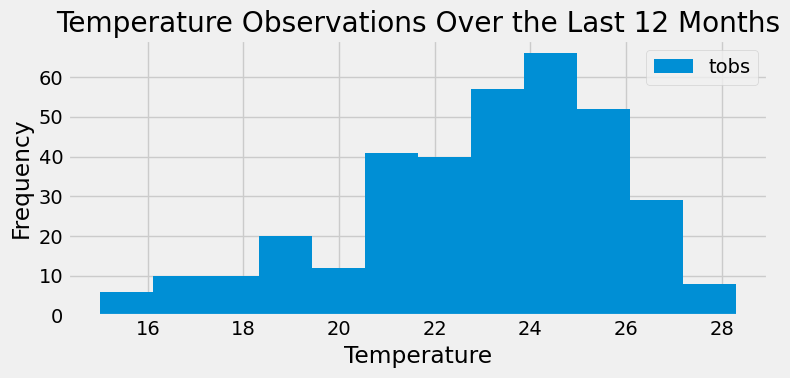

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.date, measurement.tobs).\
            filter(measurement.station == most_active_station).\
            filter(measurement.date >= one_year_ago).all()

tobs_df = pd.DataFrame(tobs_data, columns = ['date', 'tobs'])

tobs_df.plot.hist(bins=12, figsize = (8,4), title = 'Temperature Observations Over the Last 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
